# Find Best Paths Between ODs

In [1]:
import sys
import json
default = {'scenario': 'base', 'training_folder': '../..'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))

sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.model import stepmodel

import pandas as pd

if manual:
    %matplotlib inline

SQLalchemy is not installed. No support for SQL output.


## Read Model

In [2]:
sm = stepmodel.read_zippedpickles(argv['training_folder'] + '/model/{scen}/walk_model'.format(scen=argv['scenario']))

lines: 100%|██████████| 24/24 [00:00<00:00, 43.31it/s]     


# Preparation

In [3]:
# Set headway of 5 minutes for each transport line
sm.links['headway'] = 300

# Set car speed as 25% faster than bus speed
bus = sm.links.loc[sm.links['route_type'] == 'bus']
car_speed = (bus['length'].sum() / bus['time'].sum()) * 1.25
sm.road_links['time'] = sm.road_links['length'] / car_speed # m/s
print(f'Car Speed: {car_speed * 3.6}  km/h')

# Set walk time on road network
sm.road_links['walk_time'] = sm.road_links['time'] * 3 # walk three times slower than car

KeyError: 'road_length'

# PT Pathfinder
## Walk On Road
People walks on the road network, slower computation

In [ ]:
wor = sm.copy()
wor.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=True)

path_analysis: 100%|██████████| 12100/12100 [00:00<00:00, 53600.59it/s]


## As the Crow Llies
People walks on dedicated access and egress links only 

In [ ]:
acf = sm.copy()
acf.step_pt_pathfinder(broken_modes=False, broken_routes=False)

path_analysis: 100%|██████████| 12100/12100 [00:00<00:00, 63302.43it/s]


In [ ]:
# here we chose to use the ACF paths
sm.pt_los = acf.pt_los

# Road Pathfinder

In [ ]:
sm.step_road_pathfinder(method = 'aon')
sm.car_los.drop(columns=['gtime'], inplace=True)

self.volumes does not exist. od generated with self.zones


# Export

In [ ]:
sm.to_zippedpickles(argv['training_folder'] + '/model/{scen}/aon_pathfinder'.format(scen=argv['scenario']))  

car_los: 100%|██████████| 31/31 [00:01<00:00, 20.60it/s]      


# PLOT

In [ ]:
if not manual:
    end_of_notebook
    
import matplotlib.pyplot as plt
import numpy as np

(0.0, 4000.0)

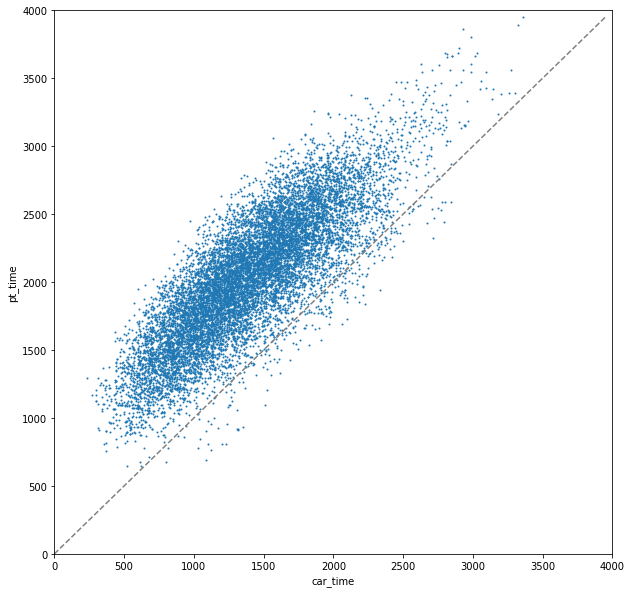

In [ ]:
sm.pt_los['pt_time'] = sm.pt_los['gtime']
sm.car_los['car_time'] = sm.car_los['time']
los = pd.merge(sm.pt_los, sm.car_los, on=['origin', 'destination'])
los = los.loc[los['origin'] != los['destination']]
los.plot(kind='scatter', x='car_time', y='pt_time', figsize=[10, 10], s=1)

x = y = np.linspace(0, max(los['pt_time']))
plt.plot(x, y, linestyle='--', color='grey')
plt.xlim([0, np.round(max(los['pt_time']), -3)])
plt.ylim([0, np.round(max(los['pt_time']), -3)])

# END